# Yandex.Afisha Business Analysis Report
### Author: Xia Cui 

### Introduction 

Yandex.Afisha is an app that helps users find out about events like movie showings, exhibitions, gigs, etc. and buy tickets. This report examines the data of Yandex.Afisha coming from three sources: data on visits from server logs from June 2017 through May 2018, information on all orders for the same period, and the marketing expenses statistics. 

The analysis of the data intends to address the following key questions: 
- How people use the product
- When they start to buy
- How much money each customer brings
- When they pay off
- Which marketing channels are effective and which are not

By addressing the above questions, the goal of the report is to help marketing experts from Yandex.Afisha make effective investments in marketing. 

In what follows, the datasets will be imported and checked first, followed by some basic transformation to facilitate analysis. Then the key metrics in product, sales, and marketing will be calculated and reported. The report concludes with advice for marketing experts on how much money to invest and for which sources and platforms. 

### Table of content 
#### [Part 1: Data importing](#importing)  
#### [Part 2: Data preprocessing and transformation](#preprocessing)  
#### [Part 3: Calculating metrics-product](#product)  
#### [Part 4: Calculating metrics-sales](#sales) 
#### [Part 5: Calculating metrics-marketing](#marketing)  
#### [Part 6: Findings and conclusions](#conclusion)  

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats as st
from IPython.display import display
import seaborn as sns
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
import warnings
warnings.filterwarnings("ignore")

### Part 1: Data importing

<a id="importing"></a>

**Optimizing data**

Before we import the whole datasets, let's take a look at the first 100 rows of each.

In [2]:
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log_us.csv', nrows=100)
df2 = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log_us.csv', nrows=100)
df3 = pd.read_csv('https://code.s3.yandex.net/datasets/costs_us.csv', nrows=100)

We will take a look at the information of the first dataset. 

In [3]:
df1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     100 non-null    object
 1   End Ts     100 non-null    object
 2   Source Id  100 non-null    int64 
 3   Start Ts   100 non-null    object
 4   Uid        100 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 22.7 KB


Among these, 'End Ts' and 'Start Ts' should be of datetime data type. Device is likely to be a categorical variable. But let's check. 

In [4]:
df1['Device'].value_counts()

desktop    73
touch      27
Name: Device, dtype: int64

Yes indeed. There are only two device types. Using such information, we can then optimize the dataset upon its importing. 

In [2]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log_us.csv', 
                  dtype={'Device': 'category', 'Source Id': 'category'},
                  parse_dates=['Start Ts', 'End Ts']) 

Below we repeat the same process with the 2nd and 3rd dataset. 

In [6]:
df2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   100 non-null    object 
 1   Revenue  100 non-null    float64
 2   Uid      100 non-null    uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 9.1 KB


In [3]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log_us.csv',
                    parse_dates=['Buy Ts'])

In [8]:
df3.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  100 non-null    int64  
 1   dt         100 non-null    object 
 2   costs      100 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.2 KB


In [4]:
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_us.csv',
                    dtype={'Source Id': 'category'}, 
                    parse_dates=['dt'])

**Checking data**

Now all datasets are imported and saved to a variable. Let's have a look at their shape, as well as the first 5 rows in each to get a better understanding of the data. We'll also check if they have NA values and duplicated rows.

In [10]:
visits.shape

(359400, 5)

In [11]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [12]:
print (visits['Start Ts'].min(), visits['Start Ts'].max())

2017-06-01 00:01:00 2018-05-31 23:59:00


In [13]:
visits.isna().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [14]:
visits.duplicated().sum()

0

In [15]:
orders.shape

(50415, 3)

In [16]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [17]:
print(orders['Buy Ts'].min(), orders['Buy Ts'].max())

2017-06-01 00:10:00 2018-06-01 00:02:00


In [18]:
orders.isna().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [19]:
orders.duplicated().sum()

0

In [20]:
costs.shape

(2542, 3)

In [21]:
print(costs['dt'].min(), costs['dt'].max())

2017-06-01 00:00:00 2018-05-31 00:00:00


In [22]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [23]:
costs.isna().sum()

source_id    0
dt           0
costs        0
dtype: int64

In [24]:
costs.duplicated().sum()

0

### Part 1 Summary 

Now we have three datasets: 

- The *visits* data come from server logs of website visits, showing information of user's unique identifier, their device, the session start and end date and time, as well as the identifier of the ad source the user came from. 

- The *orders* data include the unique identifier of the user making an order, order date and time, and Yandex.Afisha's revenue from the order

- The *costs* data gives information on marketing expenses, including the ad source identifier, date, and the expenses on this ad source on this day

All three datasets look clean and do not contain NA values. One issue we found is that the columns names. Some of these need to be modified so as to conform to naming protocols. 

While *visits* and *costs* dataset contains records from June 2017 to May 2018, *orders*  contains information dated '2018-06-01'. This is likely to be an error but we will double check on this in the next step.  

Also, it would be great if the visits and orders data have a common variable such as session_id which we can use to join them later. We can certainly still do so using *uid* in combination with the timestamp information but this is less straightforward. It's something that might be brought up to the data team. 

To facilitate analysis, we will also need to create additional datetime columns showing the week, month, and year of the activity. 

### Part 2: Data preprocessing and transformation

<a id="preprocessing"></a>

**Changing column names**

In [5]:
visits.columns = visits.columns.str.lower()

In [6]:
visits = visits.rename(columns={
    'end ts': 'end_ts',
    'start ts': 'start_ts',
    'source id': 'source_id'
})

In [7]:
orders.columns = orders.columns.str.lower()

In [8]:
orders = orders.rename(columns={'buy ts': 'order_ts'})

In [9]:
costs = costs.rename(columns={'dt': 'date'})

**Adding additional datetime columns to the *visits* data** 

First, let's add some addition columns to the visits dataset, showing the visit date, week, month, as well as the first visit date, week, and month for each customer. For week and month, let's show these in 'datetime64' data type in which case, we won't need a separate 'year' column. 

In [10]:
visits['date'] = visits['start_ts'].dt.date

In [11]:
visits['month'] = visits['start_ts'].astype('datetime64[M]')

In [12]:
visits['date'] = pd.to_datetime(visits['date'])

In [13]:
visits['week'] = visits['date'] - pd.to_timedelta(
        visits['date'].dt.dayofweek, unit='d')

Now, let's first create a first_visit variable with similar datetime informations about the customers' first visit, and then join it with the visits dataset. 

In [14]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,2017-12-18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,2018-05-14
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,2017-12-25


In [15]:
first_visit = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()

In [16]:
first_visit.columns = ['uid', 'first_visit_ts']

In [17]:
first_visit['first_visit_date'] = first_visit['first_visit_ts'].dt.date

In [18]:
first_visit['first_visit_month'] = first_visit['first_visit_date'].astype('datetime64[M]')

In [19]:
first_visit['first_visit_date']  = pd.to_datetime(first_visit['first_visit_date'] )

In [20]:
first_visit['first_visit_week'] = first_visit['first_visit_date'] - pd.to_timedelta(
        first_visit['first_visit_date'].dt.dayofweek, unit='d')

In [21]:
first_visit.head()

,uid,first_visit_ts,first_visit_date,first_visit_month,first_visit_week
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01,2018-02-26
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01,2018-02-05
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01,2017-06-05
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2017-09-18
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01,2017-09-25


In [22]:
visits=visits.merge(first_visit, on = 'uid')

In [23]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week,first_visit_ts,first_visit_date,first_visit_month,first_visit_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,2017-12-18,2017-12-20 17:20:00,2017-12-20,2017-12-01,2017-12-18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,2018-02-19,2018-02-19 16:53:00,2018-02-19,2018-02-01,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-26,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,2018-05-14,2018-03-09 20:05:00,2018-03-09,2018-03-01,2018-03-05
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-01,2018-03-05,2018-03-09 20:05:00,2018-03-09,2018-03-01,2018-03-05


**Adding additional datetime columns to the *orders* data**

In [43]:
orders['order_date'] = orders['order_ts'].dt.date

In [44]:
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

We know when checking the data that *orders* contains information on '2018-06-01'. Let's see how many rows are from that date. 

In [45]:
orders[pd.to_datetime(orders['order_date']) == '2018-06-01']

,order_ts,revenue,uid,order_date,order_month
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01,2018-06-01


There is only one row. Let's get rid of it so all three datasets are from the same period. 

In [46]:
orders = orders[pd.to_datetime(orders['order_date']) != '2018-06-01']

In [47]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['order_week'] = orders['order_date'] - pd.to_timedelta(
        orders['order_date'].dt.dayofweek, unit='d')

Let's create the variable *first_orders* containing similar columns and then join it to the orders dataset. 

In [48]:
first_orders = orders.groupby('uid').agg({'order_ts': 'min'}).reset_index()

In [49]:
first_orders.columns = ['uid', 'first_order_ts']

In [50]:
first_orders['first_order_date'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_date'].astype('datetime64[M]')

In [51]:
first_orders['first_order_date'] = pd.to_datetime(first_orders['first_order_date'])
first_orders['first_order_week'] = first_orders['first_order_date'] - pd.to_timedelta(
        first_orders['first_order_date'].dt.dayofweek, unit='d')

In [52]:
orders=orders.merge(first_orders, on = 'uid')

In [53]:
orders.head()

,order_ts,revenue,uid,order_date,order_month,order_week,first_order_ts,first_order_date,first_order_month,first_order_week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-05-29,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-05-29
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-05-29,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-05-29
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-05-29,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-05-29
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-05-29,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-05-29
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-05-29,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-05-29


**Creating additional columns for the costs dataset**

In [54]:
costs['cost_month'] = costs['date'].astype('datetime64[M]')

In [55]:
costs.head()

,source_id,date,costs,cost_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


### Part 2 summary 

Now the datasets are ready for calculating metrics and generating reports. 

### Part 3: Calculating metrics - product

<a id="product"></a>

In this section, we will find out the following informaion: 
- How many people use Yandex.Afisha every day, week, and month?
- How many sessions are there per day? 
- What is the length of each session?
- How often do users come back?

The *visits* dataset contains all the information we need to find out these information. 

In [56]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week,first_visit_ts,first_visit_date,first_visit_month,first_visit_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,2017-12-18,2017-12-20 17:20:00,2017-12-20,2017-12-01,2017-12-18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,2018-02-19,2018-02-19 16:53:00,2018-02-19,2018-02-01,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-26,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,2018-05-14,2018-03-09 20:05:00,2018-03-09,2018-03-01,2018-03-05
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-01,2018-03-05,2018-03-09 20:05:00,2018-03-09,2018-03-01,2018-03-05


#### 3.1 Sessions and users per month

In [57]:
sessions_by_month = visits.groupby('month').agg(
    {'uid': ['count', 'nunique']})
sessions_by_month.columns = ['n_sessions', 'n_users']
sessions_by_month = sessions_by_month.reset_index()
sessions_by_month['session_per_user'] = sessions_by_month['n_sessions'] / \
    sessions_by_month['n_users']

In [58]:
sessions_by_month

,month,n_sessions,n_users,session_per_user
0,2017-06-01,16505,13259,1.244815
1,2017-07-01,17828,14183,1.256998
2,2017-08-01,14355,11631,1.234202
3,2017-09-01,23907,18975,1.259921
4,2017-10-01,37903,29692,1.276539
5,2017-11-01,43969,32797,1.340641
6,2017-12-01,41983,31557,1.330386
7,2018-01-01,36939,28716,1.286356
8,2018-02-01,37182,28749,1.293332
9,2018-03-01,35679,27473,1.298693


In [59]:
sessions_by_month[['n_users', 'n_sessions',
                   'session_per_user']].describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
n_users,12.0,23228.42,7546.38,11631.00,17777.00,24240.50,28984.75,32797.00
n_sessions,12.0,29950.00,10307.84,14355.00,22387.25,31157.00,37362.25,43969.00
session_per_user,12.0,1.28,0.03,1.23,1.26,1.28,1.29,1.34


In [60]:
sessions_by_month['month'] = sessions_by_month['month'].dt.strftime('%Y-%m')

Let's plot the sessions and users each month to month on the same graph. 

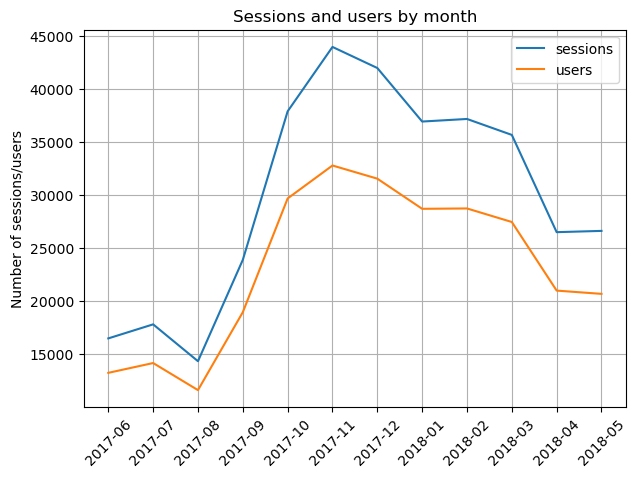

In [61]:
plt.plot(sessions_by_month['month'], sessions_by_month['n_sessions'])
plt.plot(sessions_by_month['month'], sessions_by_month['n_users'])
plt.title('Sessions and users by month')
plt.legend(['sessions', 'users'])
plt.xticks(rotation=45)
plt.ylabel('Number of sessions/users')
plt.grid()
plt.show()

We can see from the above that the monthly sessions and users rise and fall following the same pattern, which makes sense. August 2017 seems to have the lowest number of users and sessions(11631, 32797), whereas November 2017 saw the highest in both(14355,43969). 

This may reflect seasonal changes in app use, or the popularity of the app itself among users. We won't know for sure given we only have data of one year. 

The average use of the app by user each month is around 1.28, which is not great. 

#### 3.2 Sessions and users per week

In [62]:
sessions_by_week = visits.groupby('week').agg(
    {'uid': ['count', 'nunique']})
sessions_by_week.columns = ['n_sessions', 'n_users']
sessions_by_week['session_per_user'] = sessions_by_week['n_sessions'] / \
    sessions_by_week['n_users']
sessions_by_week = sessions_by_week.reset_index()

In [63]:
sessions_by_week.head()

,week,n_sessions,n_users,session_per_user
0,2017-05-29,2309,2021,1.142504
1,2017-06-05,4931,4129,1.194236
2,2017-06-12,3214,2812,1.142959
3,2017-06-19,3273,2878,1.137248
4,2017-06-26,3514,3064,1.146867


In [64]:
sessions_by_week[['n_users', 'n_sessions', 'session_per_user']
                 ].describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
n_users,53.0,5716.25,2049.90,2021.00,4128.00,5740.00,7401.00,10586.00
n_sessions,53.0,6781.13,2549.57,2309.00,4803.00,6768.00,8712.00,13572.00
session_per_user,53.0,1.18,0.03,1.14,1.16,1.18,1.19,1.28


In [65]:
sessions_by_week['week'] = sessions_by_week['week'].dt.strftime('%Y-%m-%d')

Now, let's plot to show how many sessions and user week by week. 

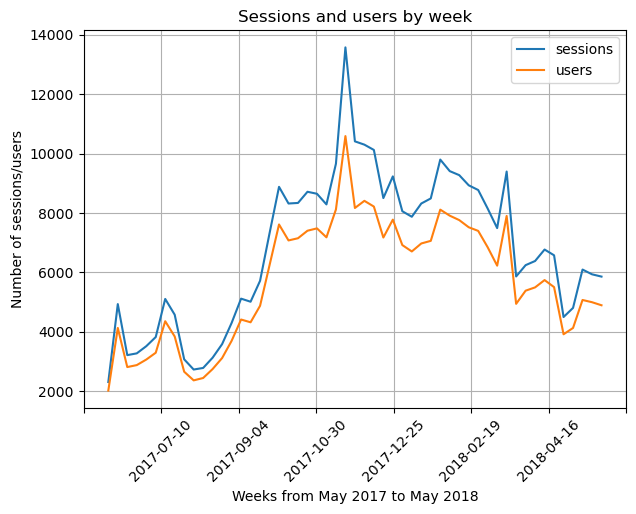

In [66]:
plt.plot(sessions_by_week['week'], sessions_by_week['n_sessions'])
plt.plot(sessions_by_week['week'], sessions_by_week['n_users'])
plt.title('Sessions and users by week')
plt.legend(['sessions', 'users'])
xmin, xmax = plt.xlim()
plt.xticks(np.linspace(xmin, xmax, 8), rotation=45)
plt.ylabel('Number of sessions/users')
plt.xlabel('Weeks from May 2017 to May 2018')
plt.grid()
plt.show()

Weekly sessions and users can reveal a little more fluctuation than the monthly stats. In addition to the overall peak in November, we can see some small peaks in some weeks in January and March. These could be the weeks with more events happening. The number of users range from just over 2000, to above 10,000. On average, a user spent 1.18 sessions a week on the app. 

#### 3.3 Sessions and users per day

In [67]:
sessions_by_day = visits.groupby('date').agg({'uid': ['count', 'nunique']})
sessions_by_day.columns = ['n_sessions', 'n_users']
sessions_by_day = sessions_by_day.reset_index()
sessions_by_day['session_per_user'] = sessions_by_day['n_sessions'] / \
    sessions_by_day['n_users']

In [68]:
sessions_by_day.head()

,date,n_sessions,n_users,session_per_user
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237
2,2017-06-03,477,445,1.071910
3,2017-06-04,510,476,1.071429
4,2017-06-05,893,820,1.089024


In [69]:
sessions_by_day['n_sessions'].sum()/sessions_by_day['n_users'].sum()

1.0874136559064957

In [70]:
sessions_by_day[['n_users', 'n_sessions', 'session_per_user']
                ].describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
n_users,364.0,907.99,370.51,1.0,594.00,921.00,1173.00,3319.00
n_sessions,364.0,987.36,418.99,1.0,635.50,1003.00,1280.00,4042.00
session_per_user,364.0,1.08,0.02,1.0,1.07,1.08,1.09,1.22


On average, there is just slightly over 1 session per user per day. There are also some quite extreme numbers on both ends. Let's plot to show how the daily sessions change over the year first. 

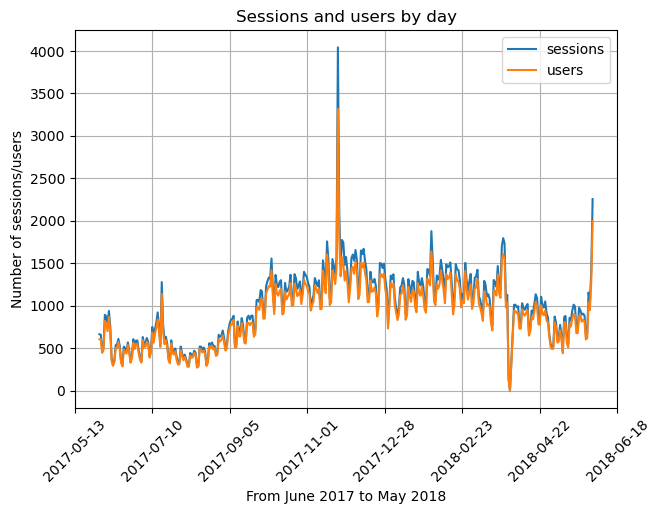

In [71]:
plt.plot(sessions_by_day['date'], sessions_by_day['n_sessions'])
plt.plot(sessions_by_day['date'], sessions_by_day['n_users'])
plt.title('Sessions and users by day')
plt.legend(['sessions', 'users'])
xmin, xmax = plt.xlim()
plt.xticks(np.linspace(xmin, xmax, 8), rotation=45)
plt.ylabel('Number of sessions/users')
plt.xlabel('From June 2017 to May 2018')
plt.grid()
plt.show()

Previous graphs on monthly and weekly session lead us to believe that there are certain periods during which the apps were used a lot more than others. Could it be just a specific day? The plot of daily sessions shows that while for most days the number of sessions and users are under 1500, there is one day with extreme high number(over 4000)which might have brought up the weekly and monthly session number containing that day. Similarly, there are also some extremely low user days. Let's check out when these happened. 

In [72]:
sessions_by_day[sessions_by_day['n_sessions'] == sessions_by_day['n_sessions'].max()]

,date,n_sessions,n_users,session_per_user
176,2017-11-24,4042,3319,1.217837


What happened to, or on, November 24th 2017? Is there a special event, a marketing hit? Out of curiosity, let's quickly find out how the marketing expense on that day compares to other days, as well as the revenues. 

In [73]:
costs[costs['date'] == '2017-11-24']['costs'].sum()

3458.8600000000006

In [74]:
costs.groupby('date').agg({'costs': 'sum'}).describe()

,costs
count,364.000000
mean,904.207747
std,396.956825
min,0.700000
25%,595.682500
50%,873.655000
75%,1155.605000
max,3458.860000


In [75]:
orders[orders['order_date'] == '2017-11-24']['revenue'].sum()

3398.3500000000004

In [76]:
orders.groupby('order_date').agg({'revenue': 'sum'}).describe()

,revenue
count,363.000000
mean,694.363030
std,502.697626
min,29.220000
25%,382.070000
50%,598.590000
75%,870.070000
max,4661.330000


In [77]:
revenue_by_day = orders.groupby('order_date').agg({'revenue': 'sum'}).reset_index()
revenue_by_day[revenue_by_day['revenue'] == revenue_by_day['revenue'].max()]

,order_date,revenue
192,2017-12-10,4661.33


Yes indeed. While on most days the marketing expense is under 1200, on November 24th, 2017, the cost was as high as 3458.86, leading to the peak of app visits. 

Revenue wise, November 24th, 2017 does have a rather high revenue compare to most other days. However, the day with the highest revenue is actually a little after: December 10th, 2017. It's possible that the big spending on marketing campaigns, although seeing some instant response, also have some sustained effects in the weeks after. We will have a closer look at sales and maketing later in this report. 

On the other extreme end, we also notice around April there is one day with almost zero session. Let's find out which day is that. 

In [78]:
sessions_by_day[sessions_by_day['n_sessions'] == sessions_by_day['n_sessions'].min()]

,date,n_sessions,n_users,session_per_user
303,2018-03-31,1,1,1.0


In [79]:
costs[costs['date'] == '2018-03-31']['costs'].sum()

0.7

It turned out to be the last day in March 2018. It also happens to be the day the marketing spend is almost 0. What happened is beyond our knowledge in this report, but at least we know marketing seems to work! Higher spending led to more visits, and no spend no visits. This is also not good news, because it indicates the customers don't really stay, in other words. They are not loyal customers. 

#### 3.5 User activity

Using the visits data, we can also find out how many unique visits the app gets daily, weekly, and monthly. This tells to what extent the app is interesting to users who aren't yet familiar with it. We will be using three metrics here:
- DAU — the number of daily active (unique) users
- WAU — the number of weekly active users
- MAU — the number of monthly active users

Then we can use the above to calculate the sticky factor, which indicates how loyal the audience is.

In [80]:
visits.groupby('date').agg({'uid': 'nunique'}).min()

uid    1
dtype: int64

In [81]:
dau = visits.groupby('date').agg({'uid': 'nunique'}).mean()
wau = visits.groupby('week').agg({'uid': 'nunique'}).mean()
mau = visits.groupby('month').agg({'uid': 'nunique'}).mean()
print('daily active users: {0}\nweekly active users: {1}\nmonthly active users: {2}'.format(
    float(dau), float(wau), float(mau)))

daily active users: 907.9917582417582
weekly active users: 5716.245283018868
monthly active users: 23228.416666666668


The app certainly seems popular, attracting a steady flow of users. 

In [82]:
print('Sticky factor expressed as the ratio of daily and weekly active users : {0}'.format(
    float(dau/wau*100)))
print('Sticky factor expressed as the ratio of daily and monthly active users : {0}'.format(
    float(dau/mau*100)))

Sticky factor expressed as the ratio of daily and weekly active users : 15.88440861589881
Sticky factor expressed as the ratio of daily and monthly active users : 3.908969652437603


However, user stickiness doesn't look promising. The company may have a potential problem of lacking customer loyalty. This is, however, a task beyond the capacity of the marketing department. Are the products designed to attract repetitive purchases? Are their strategies taken to engage the existing customers. There are a lot to think. 

#### 3.4 Typical sesson length

Now let's have a look at how long do users use the app and how that differs by device. 

In [83]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [84]:
visits['session_duration'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration, dtype: float64

While 75% of the sessions are 840 seconds (14 minutes) or less, the longest session is as long as 84480 seconds(almost a day), which is strange. The distribution is very much right skewed. Let's take a look at its histogram. We'll set the range to be under 3000 seconds. 

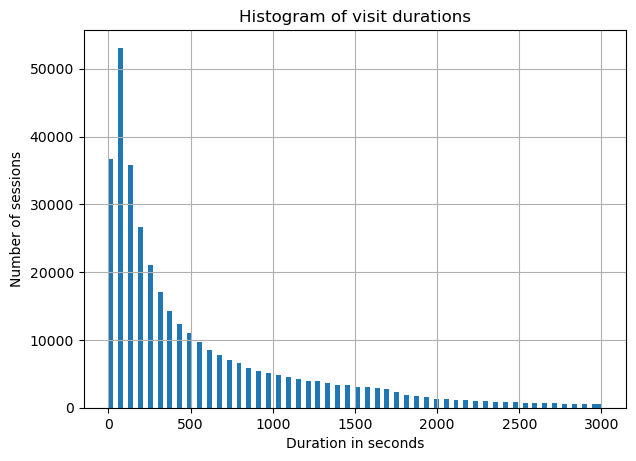

In [85]:
visits['session_duration'].hist(bins=100, range=(0, 3000))
plt.title('Histogram of visit durations')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of sessions')
plt.show()

From the stats and histogram above we get to know that half of the users used the app for 5 minuts and under, 75% under 14 minutes. Somewhere between 0 and 100 seems to be the most popular session length. Let's find out what this typical duration is! 

In [86]:
visits['session_duration'].mode()

0    60
dtype: int64

A typical session duration is 60 seconds. This seems to be a little short if any orders are to happen. Let's have a look at session duration by device. 

**Session duration by device**

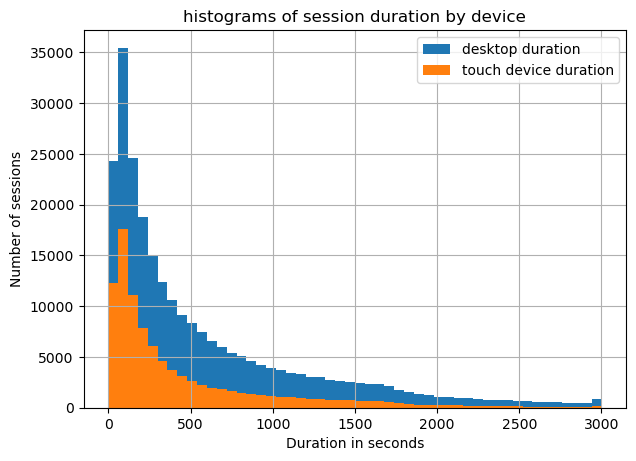

In [87]:
visits.query('device=="desktop"')['session_duration'].hist(bins=50, range=(0, 3000))
visits.query('device=="touch"')['session_duration'].hist(bins=50, range=(0, 3000))
plt.legend(['desktop duration', 'touch device duration'])
plt.title('histograms of session duration by device')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of sessions')
plt.show()

In [88]:
visits.query('device=="desktop"')['session_duration'].median()

360.0

In [89]:
visits.query('device=="touch"')['session_duration'].median()

180.0

It's quite obvious from the plots above that session duration for desktop users overall is a lot higher than touch device users. The reasons for this is worth investigating. Are there any barriers for touch device users. Is the app easier to investigate when using desktop? Given that people are more and more relying on their phones, the tech department will need to work towards optimizing user experience with touch devices. 

#### 3.5 How often do users come back?

To find out information about how often users come back, we will calculate the metric: **retention** for user activity on the app. For this purpose, let's form monthly cohorts and track their visit to the app. An alternative method is to form weekly cohorts. The reason for choosing monthly cohorts is that user activity on an app that help users to navigate entertainment information might be affected more by what month of the year it is. 

First, let's create the 'cohort_lifetime' column. 

In [90]:
visits['cohort_lifetime'] = (
    visits['month'] - visits['first_visit_month'])/np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Using groupby, we will find out the number of unique users per month for each cohort.

In [91]:
cohorts = visits.groupby(['first_visit_month', 'cohort_lifetime']).agg({
    'uid': 'nunique'}).reset_index()

Let's get the initial users' count, which is when 'cohort_lifetime' is 0. 

In [92]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][[
    'first_visit_month', 'uid']]

In [93]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [94]:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month') 

In [95]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

In [96]:
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

Let's now compile a pivot table and make a heatmap for it. 

In [97]:
retention_pivot = cohorts.pivot_table(
    index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')

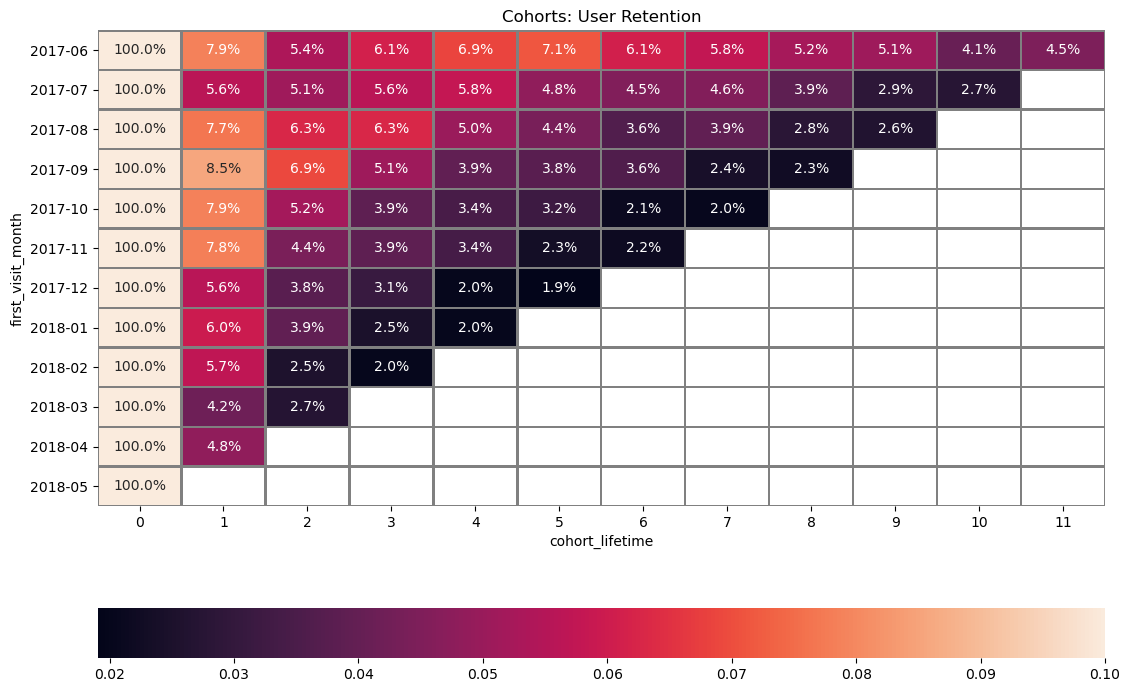

In [98]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',
           vmax=0.1, cbar_kws= {'orientation': 'horizontal'})
plt.show()

In [99]:
retention_pivot.mean(axis=0)

cohort_lifetime
0     1.000000
1     0.065167
2     0.046333
3     0.042760
4     0.040595
5     0.039444
6     0.036957
7     0.037509
8     0.035465
9     0.035159
10    0.034062
11    0.044951
dtype: float64

Except for the first two cohorts, where the retention rate picked up after the initial drop, all cohorts see an unitial drop followed by gradual decrease in retention rates. 

For the bigger cohorts(e.g. October 2017 to March 2018), the retention rates seem to be even lower than others. 

Our suspesion from earlier sections is proved. Users are not really staying with the app. This needs to be brought up with the marketing or app service department. A possible further investigation of user retention rate is to check on this by ad source. As we will be doing that later when analysing user revenues, let's skip that in this section. 

### Part 3 summary 

In this section, we find out the information about how user visits the app, the daily, weekly and monthly sessions, the session duration, and user retention rates. It seems that even on a monthy basis, the average number of session per user is at most 1.34. If we are to boost the app revenue, this number will need to pick up and the app will need to work on improving its retention rates. 

In the next section, we will investigate the sales on the app. 

### Part 4: Calculating metrics - sales

<a id="sales"></a>

In this section, we intend to find out the following information using *visits* and *orders* datasets. 

- When do people start buying? Or in other words, what is the time that elapsed between first visit and first order.

- How many orders do they make during a given period of time?

- What is the average purchase size?

- How much money do they bring? (LTV)

This information will give insights on the business' financial health. 

#### 4.1 How many made an order and how long did they wait?

Previously, we created two variables: *first_visit* and *first_orders*. Let's combine these two using 'uid'. 

In [100]:
visit_to_order = pd.merge(first_visit, first_orders, on='uid')

In [101]:
visit_to_order.head()

,uid,first_visit_ts,first_visit_date,first_visit_month,first_visit_week,first_order_ts,first_order_date,first_order_month,first_order_week
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2017-09-18,2018-01-03 21:51:00,2018-01-03,2018-01-01,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-05-29,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-05-29
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-09,2017-10-11 18:33:00,2017-10-11,2017-10-01,2017-10-09
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-22,2018-01-28 15:54:00,2018-01-28,2018-01-01,2018-01-22
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-20,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-20


In [102]:
visit_to_order['uid'].nunique()/visits['uid'].nunique()

0.160065565436146

Approximately 16% of the users who visited the app actually made order(s). Now let's find out how long it took them to do that. 

In [103]:
visit_to_order['lapsed_days'] = (visit_to_order['first_order_date'] - \
    visit_to_order['first_visit_date']).dt.days

In [104]:
visit_to_order['lapsed_days'].describe()

count    36522.000000
mean        16.896336
std         47.071771
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: lapsed_days, dtype: float64

Okay. We can see that 75% of users placed an order within 2 days, and 50% on the same day. Strange enough, some waited almost a year before they made an order. 

Out of interest, let's divide the users into three groups, those who made an order on the same day of first visit, those who made an order not on the same day but within 2 days, and the others. 

In [105]:
same_day_conversion = visit_to_order[visit_to_order['lapsed_days'] == 0]['uid']
two_day_conversion = visit_to_order[(visit_to_order['lapsed_days'] <= 2) & (
    visit_to_order['lapsed_days'] > 0)]['uid']
other_conversion = visit_to_order[visit_to_order['lapsed_days'] > 2]['uid']

**How the three groups differ in their use of devices and marketing channels**

First, let's have a look at how three different groups differ in their use of devices. We will calculate the percentage of users using desktop or touch for each group.

In [106]:
visits[visits['uid'].isin(same_day_conversion)
       ]['device'].value_counts()/len(visits[visits['uid'].isin(same_day_conversion)])

desktop    0.811198
touch      0.188802
Name: device, dtype: float64

In [107]:
visits[visits['uid'].isin(two_day_conversion)]['device'].value_counts(
)/len(visits[visits['uid'].isin(two_day_conversion)])

desktop    0.780584
touch      0.219416
Name: device, dtype: float64

In [108]:
visits[visits['uid'].isin(other_conversion)]['device'].value_counts(
)/len(visits[visits['uid'].isin(other_conversion)])

desktop    0.798127
touch      0.201873
Name: device, dtype: float64

We can see that among the same day conversion users, there is a slightly higher percentage of desktop users than the other two groups. While the difference is not exactly alarming, is it possible that it is easier to make an order using desktop than using touch devices?

let's see if the three groups differ in their ad sources. We will calculate the percentage of converted users by ad source for each group, and then plot them to compare. 

In [109]:
df1 = (visits[visits['uid'].isin(same_day_conversion)]['source_id'].value_counts(
)/len(visits[visits['uid'].isin(same_day_conversion)])).to_frame().reset_index()
df1.columns = ['source_id', 'same_day_conversion(%)']

In [110]:
df2 = (visits[visits['uid'].isin(two_day_conversion)]['source_id'].value_counts(
)/len(visits[visits['uid'].isin(two_day_conversion)])).to_frame().reset_index()
df2.columns = ['source_id', 'two_day_conversion(%)']

In [111]:
df3 = (visits[visits['uid'].isin(other_conversion)]['source_id'].value_counts(
)/len(visits[visits['uid'].isin(other_conversion)])).to_frame().reset_index()
df3.columns = ['source_id', 'other_conversion(%)']

In [112]:
all_conversion=pd.merge(df1, df2, on='source_id', how ='outer')
all_conversion=all_conversion.merge(df3, on='source_id', how='outer')

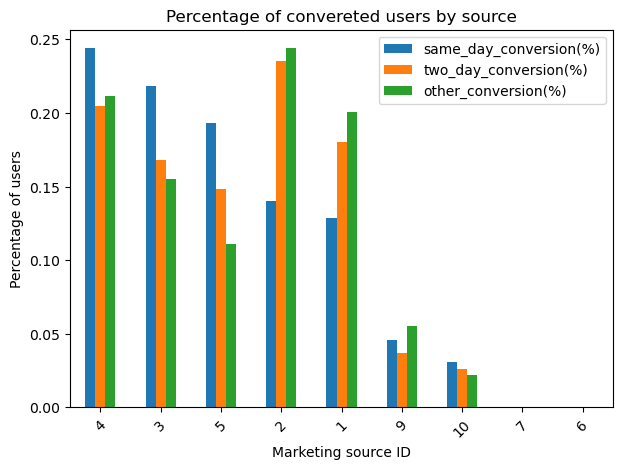

In [113]:
all_conversion.plot(x='source_id', kind='bar')
plt.title('Percentage of convereted users by source')
plt.ylabel('Percentage of users')
plt.xlabel('Marketing source ID')
plt.xticks(rotation=45)
plt.show()

Here we do not know what the source_id exactly refers too, but it seems that the top same day conversion users are attracted by ad source 4. 4 is also doing great for the other two groups, coming second after ad source 2. Ad source 4, and perhaps 2 as well, is definitely worth some attention from the marketing department. 

In contrast, ad source 7 is performing poorly, getting only one visit to order conversion. Ad source 10 is also not doing great. These will need some special attention too. 

Later in the report, we will take a closer look at how the different sources of adversiting perform in generating profits. 

Now we know how long users typically wait from their first visit to their first purchase. Let's also find out when users' purchases overall are made in relation to their first visit. Given previous analysis shows a significant amount of orders are place on day 0, we will express the duration in hours. 

In [114]:
lapse_to_order = orders[['uid', 'order_ts']].merge(
    first_visit[['uid', 'first_visit_ts']], how='left', on='uid')

In [115]:
lapse_to_order['lapse'] = (lapse_to_order['order_ts'] -
                           lapse_to_order['first_visit_ts']).astype('timedelta64[h]')

In [116]:
lapse_to_order['lapse'].describe()

count    50414.000000
mean       888.562661
std       1694.595176
min          0.000000
25%          0.000000
50%          3.000000
75%        921.000000
max       8744.000000
Name: lapse, dtype: float64

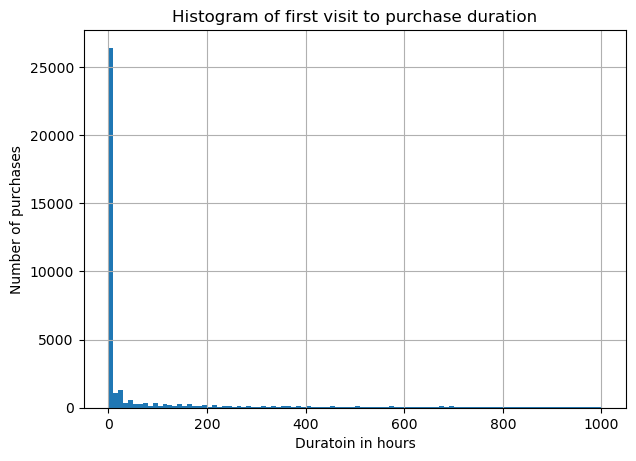

In [117]:
lapse_to_order['lapse'].hist(bins=100, range=(0, 1000))
plt.title('Histogram of first visit to purchase duration')
plt.xlabel('Duratoin in hours')
plt.ylabel('Number of purchases')
plt.show()

Amazing, half of all purchases were made within three hours of users' first visit to the app. App is doing okay in driving people to purchase. The key concern remains to be user retention. 

#### 4.2 How many orders do they make during a given period of time?

To find out the answer to this question, we first have a look at overall orders on a monthy basis. Then we will use cohort analysis to examine how each cohort performed in generating sales. Similar to when we calculating retention earlier, we will form montly cohorts here as well. 

First, a quick recap of what the orders data looks like now.

In [118]:
orders.head()

,order_ts,revenue,uid,order_date,order_month,order_week,first_order_ts,first_order_date,first_order_month,first_order_week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-05-29,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-05-29
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-05-29,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-05-29
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-05-29,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-05-29
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-05-29,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-05-29
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-05-29,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-05-29


**Orders from month to month**

Now let's see how the orders vary from month to month. 

In [119]:
orders_per_month = orders.groupby('order_month').agg({'uid': ['count', 'nunique']}).reset_index()
orders_per_month.columns = ['order_month', 'n_purchases', 'n_users']

In [120]:
orders_per_month['order_month'] = orders_per_month['order_month'].dt.strftime('%Y-%m')

In [121]:
orders_per_month['orders_per_user'] = orders_per_month['n_purchases'] / orders_per_month['n_users'] 

In [122]:
orders_per_month['orders_per_user'].describe()

count    12.000000
mean      1.222975
std       0.030695
min       1.163618
25%       1.206547
50%       1.226940
75%       1.241329
max       1.273858
Name: orders_per_user, dtype: float64

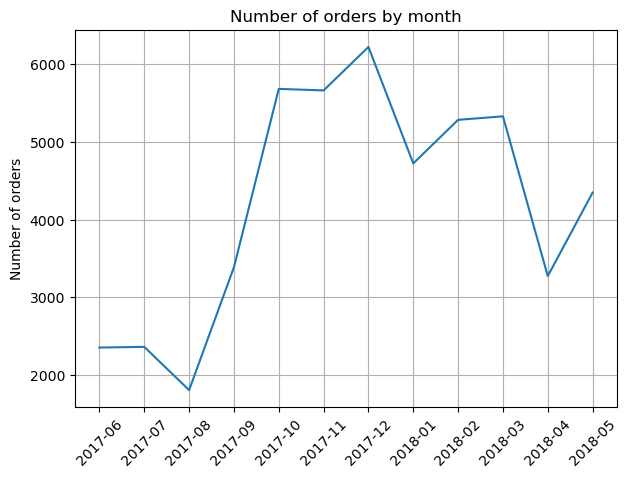

In [123]:
plt.plot(orders_per_month['order_month'], orders_per_month['n_purchases'])
plt.title('Number of orders by month')
plt.xticks(rotation=45)
plt.ylabel('Number of orders')
plt.grid()
plt.show()

As shown above, on average, a user made just over an order per month. On a monthly basis, the lowest number of orders occured in August, 2017, which is the same as when the app had the lowest number of visits. The highest number of orders were made in December 2017, where, as we previously mentioned, were two weeks after the highest marketing spending. 

Overall, between October 2017 to March 2018 we see a higher number of orders, compared with other months of the year. 

The decline in orders after December 2017 is a little concerning. We would expect that as more cohorts roll in, the orders by month will keep a upward trend but this is obviously not the case here. The external factors might be worth investigating too. For example, are there less events happening during these months, compared to the sales peak month? however, this is beyond the scope of this report. 

**Orders by cohorts from month to month**

Now, let's take a look at how each cohort performs in generating sales. We will create a variable showing the number of orders by month for each monthly cohort. 

In [124]:
cohort_sizes = orders.groupby('first_order_month').agg(
    {'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month','n_buyers']

In [125]:
cohorts_orders = orders.groupby(['first_order_month', 'order_month']).agg(
    {'uid':['count','nunique']}).reset_index()
cohorts_orders.columns=['first_order_month', 'order_month', 'n_purchases','n_active_buyers']

In [126]:
cohorts_orders['cohort_lifetime'] = (cohorts_orders['order_month'] -
                                     cohorts_orders['first_order_month']
                                     ) / np.timedelta64(1, 'M')
cohorts_orders['cohort_lifetime'] = cohorts_orders[
    'cohort_lifetime'].round().astype('int')

In [127]:
cohorts_orders=cohorts_orders.merge(cohort_sizes, on='first_order_month')

In [128]:
cohorts_orders['purchase_per_cohort_user'] = cohorts_orders['n_purchases'] / \
    cohorts_orders['n_buyers']

In [129]:
cohorts_orders['purchase_per_user'] = cohorts_orders['n_purchases'] / \
    cohorts_orders['n_active_buyers']

In [130]:
cohorts_orders['first_order_month'] = cohorts_orders['first_order_month'].dt.strftime('%Y-%m')

In [131]:
cohorts_orders.head()

,first_order_month,order_month,n_purchases,n_active_buyers,cohort_lifetime,n_buyers,purchase_per_cohort_user,purchase_per_user
0,2017-06,2017-06-01,2354,2023,0,2023,1.163618,1.163618
1,2017-06,2017-07-01,177,61,1,2023,0.087494,2.901639
2,2017-06,2017-08-01,174,50,2,2023,0.086011,3.480000
3,2017-06,2017-09-01,226,54,3,2023,0.111715,4.185185
4,2017-06,2017-10-01,292,88,4,2023,0.144340,3.318182


Let's then make a pivot table showing how the orders made by each cohort changes over their lifetime.

In [132]:
orders_pivot = cohorts_orders.pivot_table(index='first_order_month', columns='cohort_lifetime',
                                          values='n_purchases', aggfunc='mean')

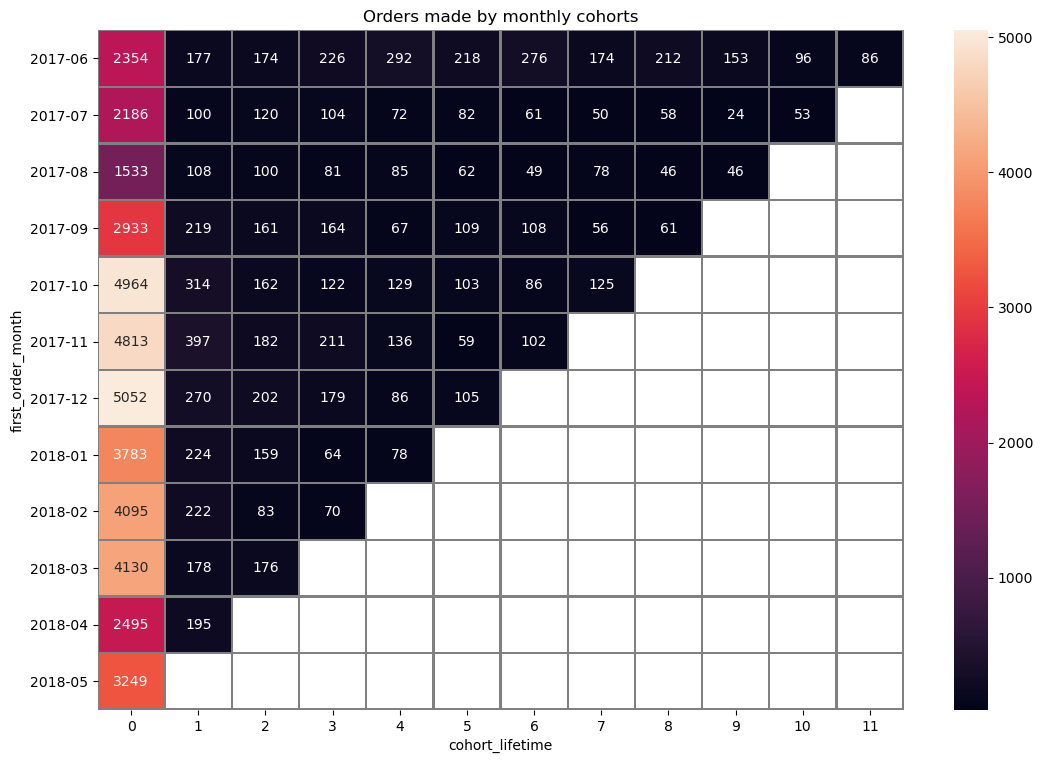

In [133]:
plt.figure(figsize=(13, 9))
plt.title('Orders made by monthly cohorts')
sns.heatmap(orders_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='grey') 
plt.yticks(rotation=0)
plt.show()

We can see from the above that most cohorts pick up their orders a little and after, following the initial drop after their first order month. 

If we have a look at cohort lifetime 5. We can see that despite the fact that October to December 2017 have the highest number of initial orders, by the time it's users' 6th month with the app, the orders dropped significantly and became more or less the same as, or even worse than, other cohorts.

Next, let's see how orders per user changed month by month. 

In [134]:
average_order_pivot = cohorts_orders.pivot_table(index='first_order_month',
                                                 columns='cohort_lifetime',
                                                 values='purchase_per_user',
                                                 aggfunc='mean').round(2)

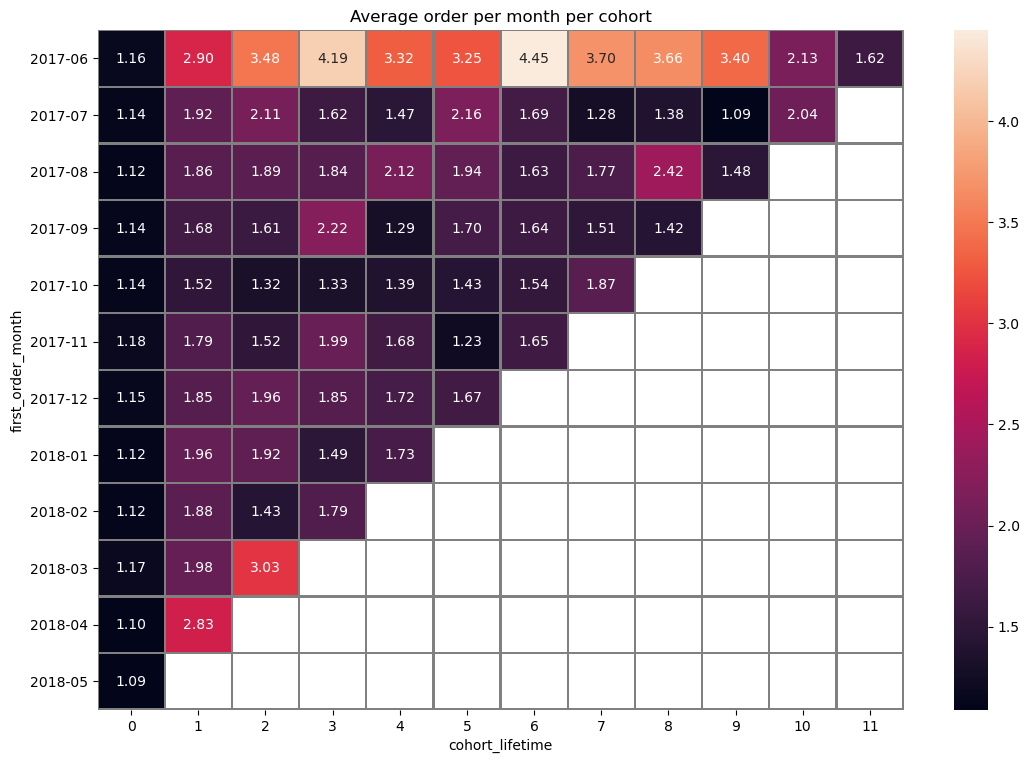

In [135]:
plt.figure(figsize=(13, 9))
plt.title('Average order per month per cohort')
sns.heatmap(average_order_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='grey') 
plt.yticks(rotation=0)
plt.show()

In [136]:
(cohorts_orders['n_purchases'].sum()/cohorts_orders['n_active_buyers'].sum()).round(2)

1.23

From above we can see that the first cohort did relatively better than the other cohorts, with the average purchase number by active users over 3 eight out of 12 month, above 4 for two months. Other cohorts see their average purchase by user mostly below 2. The March and April cohorts did see the number close to or above 3 but they are relatively new cohorts and it's hard to tell how they might perform next. 

On average, a buyer made 1.23 orders in the period this data comes from. 

However, the above only shows the average purchase by active users by month and by cohort. Let's quickly show how the cohort performs by month in their lifetime by making a pivot table taking into account of the initial cohort size and evalue how the cohort performs by month in their lifetime. 

In [137]:
average_order_cohort_pivot = cohorts_orders.pivot_table(index='first_order_month',
                                                 columns='cohort_lifetime',
                                                 values='purchase_per_cohort_user',
                                                 aggfunc='mean').round(2)
average_order_cohort_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.16,0.09,0.09,0.11,0.14,0.11,0.14,0.09,0.10,0.08,0.05,0.04
2017-07,1.14,0.05,0.06,0.05,0.04,0.04,0.03,0.03,0.03,0.01,0.03,NaN
2017-08,1.12,0.08,0.07,0.06,0.06,0.05,0.04,0.06,0.03,0.03,NaN,NaN
2017-09,1.14,0.08,0.06,0.06,0.03,0.04,0.04,0.02,0.02,NaN,NaN,NaN
2017-10,1.14,0.07,0.04,0.03,0.03,0.02,0.02,0.03,NaN,NaN,NaN,NaN
2017-11,1.18,0.10,0.04,0.05,0.03,0.01,0.02,NaN,NaN,NaN,NaN,NaN
2017-12,1.15,0.06,0.05,0.04,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.12,0.07,0.05,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.12,0.06,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
average_order_cohort_pivot.mean(axis=0)

cohort_lifetime
0     1.135833
1     0.072727
2     0.053000
3     0.048889
4     0.046250
5     0.041429
6     0.048333
7     0.046000
8     0.045000
9     0.040000
10    0.040000
11    0.040000
dtype: float64

If we consider the inital cohort size, the orders by user quickly dropped to less than 0.1 in the second month and never came back up. Once again, our inital concern was proved. The customers don't stay. They tend to make an order or 2 and then disappeared. Some did come back to purchase again but not enough. 

This could be worrying. no matter how good marketing does in attracting the customers initially, if they don't stay and continue to purchase, the marketing expense won't be paid off. 

Now we know how the orders change month to monthy and how each cohort performs in generating orders, let's look at how much money the consumers bring to the company using the LTV metric. 

#### 4.3 Average purchase size and LTV 

First, let's get the statistics of the overall purchases. 

In [139]:
orders['revenue'].describe()

count    50414.000000
mean         4.999678
std         21.818574
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [140]:
orders['revenue'].mode()

0    1.83
dtype: float64

It's interesting to see that, while 75% of the purchases are under 5, there are some extremely large value purchases. Is this even possible? Although we wouldn't know without having any further information about the app, we can still get some idea about the purchases using mean and median values. 

From the stats above, we can see that the median value for purchases is 2.5, and the mean value is 4.99, most likely due to the extreme large values. A typical purchase amount is 1.83. 

Let's also first find out the average purchase size from month to month. 

In [141]:
purchase_by_month = orders.groupby('order_month').agg(
    {'revenue': ['count', 'sum']}).reset_index()
purchase_by_month.columns = ['order_month', 'n_orders', 'sum_revenue']

In [142]:
purchase_by_month['average_purchase_size'] = purchase_by_month['sum_revenue'] / \
    purchase_by_month['n_orders']

In [143]:
purchase_by_month

,order_month,n_orders,sum_revenue,average_purchase_size
0,2017-06-01,2354,9557.49,4.060106
1,2017-07-01,2363,12539.47,5.306589
2,2017-08-01,1807,8758.78,4.847139
3,2017-09-01,3387,18345.51,5.416448
4,2017-10-01,5679,27987.70,4.928280
5,2017-11-01,5659,27069.93,4.783518
6,2017-12-01,6218,36388.60,5.852139
7,2018-01-01,4721,19417.13,4.112927
8,2018-02-01,5281,25560.54,4.840095
9,2018-03-01,5326,28834.59,5.413930


As shown above, although the number of orders and total revenues differ from month to month, sometimes quite significantly, the average purchase size remains relatively stable. This information is useful. Apparently it's an app which doesn't incur large purchases, but more rely on continuing small purchases, perhaps a subscription fee, with occasional extra. This means that user retention is even of more importance in order to keep the app profitable. The app needs to make them keep making these smaller purchases regularly. 

One of the metrics to see how well the app is performing is to calculating a customer's lifetime value, and compare that with the cost of attracting them. We will do this next. 

**LTV**

To calculate users' lifetime value, let's first get the size of the cohorts. 

We generated a *cohort_sizes* variable previously. Let's use it again here.

In [144]:
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [145]:
cohorts_revenue = orders.groupby(['first_order_month', 'order_month']).agg(
    {'revenue': 'sum'}).reset_index()
cohorts_revenue.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [146]:
report_revenue = pd.merge(cohort_sizes, cohorts_revenue, on='first_order_month')
report_revenue.head() 

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [147]:
report_revenue['age'] = (report_revenue['order_month'] -
                         report_revenue['first_order_month']) / np.timedelta64(1, 'M')
report_revenue['age'] = report_revenue['age'].round().astype('int')

Now let's calculate user's LTV. LTV (lifetime value) is the customer's lifetime value. It's the total amount of money a customer brings to the company on average by making purchases. Usually LTV is calculated as the gross profit from a customer per period.

In the case of Yandex.Afisha, we do not have information of margin rate. Therefore we will consider it as 1. Hence the 'revenue' is equal to 'gross profits'. 

In [148]:
report_revenue['ltv'] = report_revenue['revenue'] / report_revenue['n_buyers']

In [149]:
report_revenue['first_order_month'] = report_revenue[
    'first_order_month'].dt.strftime('%Y-%m')

In [150]:
output_revenue = report_revenue.pivot_table(index='first_order_month', columns='age',
                   values='ltv', aggfunc='mean').round(3)
output_revenue.cumsum(axis=1).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724,5.209,5.647,6.602,7.625,8.361,9.311,9.893,10.446,11.052,11.623,11.88
2017-07,6.010,6.345,6.969,7.328,7.505,7.661,7.781,7.923,8.084,8.231,8.387,
2017-08,5.277,5.749,6.207,6.598,7.092,7.376,7.587,7.992,8.284,8.472,,
2017-09,5.645,6.763,7.284,11.26,11.661,12.308,13.01,13.253,13.437,,,
2017-10,5.004,5.54,5.731,5.888,6.04,6.16,6.245,6.36,,,,
2017-11,5.155,5.554,5.754,6.079,6.227,6.281,6.396,,,,,
2017-12,4.738,4.998,5.923,6.988,7.301,7.639,,,,,,
2018-01,4.136,4.431,4.735,4.878,4.941,,,,,,,
2018-02,4.157,4.435,4.514,4.588,,,,,,,,


The pivot table above shows each cohort's accumulative LTV at their different lifetime age. Among them, cohort September 2017 stood out, generating 11.26 of lTV per user after only three month. It would be worthwhile to study the characteristics of this cohort to find out why. 

Next,let's take a look at the average cohort ltv at different lifetime age. 

In [151]:
output_revenue.cumsum(axis=1).mean(axis=0)

age
0      4.917000
1      5.395818
2      5.822000
3      6.689889
4      7.299000
5      7.969429
6      8.388333
7      9.084200
8     10.062750
9      9.251667
10    10.005000
11    11.880000
dtype: float64

The information above shows the average ltv of cohorts at different lifetime age. As a result of the July and August 2017 cohorts' less than desirable performance, we see a bit fluctuation around age 9. Overall, we see a customer's accumulative LTV at the end of 12 month just slightly doubles what it was in the first month. 

Knowing a customer's LTV is only half of the picture. To assess if the business is healhty, we need to know how much the company is spent on acquiring each customer. We will do this next. 

**Return of marketing investment**

Now we know how much money customers bring to the company, let's calculate the cost of getting the customers by cohorts, and the return of marketing investment. 

First, let's get the montly marketing expenses. 

In [152]:
monthly_cost = costs.groupby('cost_month').agg({'costs': 'sum'}).reset_index()

In [153]:
monthly_cost.head()

,cost_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


In [154]:
monthly_cost['cost_month']=monthly_cost['cost_month'].dt.strftime('%Y-%m')

Now we can join the monthly cost data with the report_revenue data we generated earlier. 

In [155]:
report_ = pd.merge(report_revenue, monthly_cost,
                  left_on='first_order_month', right_on='cost_month')

We can calculate the cac by dividing cost by the number of buyers. 

In [156]:
report_['cac'] = report_['costs'] / report_['n_buyers']
report_

,first_order_month,n_buyers,order_month,revenue,age,ltv,cost_month,costs,cac
0,2017-06,2023,2017-06-01,9557.49,0,4.724414,2017-06,18015.00,8.905091
1,2017-06,2023,2017-07-01,981.82,1,0.485329,2017-06,18015.00,8.905091
2,2017-06,2023,2017-08-01,885.34,2,0.437637,2017-06,18015.00,8.905091
3,2017-06,2023,2017-09-01,1931.30,3,0.954671,2017-06,18015.00,8.905091
4,2017-06,2023,2017-10-01,2068.58,4,1.022531,2017-06,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...
73,2018-03,3533,2018-04-01,1063.05,1,0.300892,2018-03,30415.27,8.608907
74,2018-03,3533,2018-05-01,1114.87,2,0.315559,2018-03,30415.27,8.608907
75,2018-04,2276,2018-04-01,10600.69,0,4.657597,2018-04,22289.38,9.793225
76,2018-04,2276,2018-05-01,1209.92,1,0.531599,2018-04,22289.38,9.793225


Now let's calculate the **return on marketing investment**. 

In [157]:
report_['romi'] = report_['ltv'] / report_['cac']

In [158]:
output_ = report_.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean')

output_.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that for the earliest cohort in the data, the cost of getting them start to pay off after 6 months. The best performing cohort is September 2017, whose cac start to pay off after just three months. 

Although from earlier analysis we know that October, November, and December 2017 have the largest cohort and initial orders, the cohorts haven't paid off even after 6 months. 

It's also worrying see that some of the earlier cohorts, July and August 2017, also haven't paid off after almost a year. All these are worth extra attention from both the markting team and app design team to see why users are not staying to spend. 

Still, let's take a look at how quickly cohorts pay off on average. 

In [159]:
output_.cumsum(axis=1).mean(axis=0)   

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

The stats above shows that on average, the cohorts start to pay off on the 7th month. However, we see a drop on the 8th month because of the poor performance of the July and August 2017 cohorts. The information from the pivot table output is more informative because it shows that there are actually only two cohorts that have been paid off so far. 

It's reasonable to be concerned with business health. What went wrong? What didn't work? What might work? While there are external factors to consider, such entertainment and events seasons, as well as internal factors such as app's user experience, what we can do in the scope of this report, is to find out how marketing is performing to attract customers to spend, and continue to spend. This is the focus of analysis next. 

### Part 5: Calculating metrics - marketing

<a id="marketing"></a>

In this section, we will find out the following key information: 

- How much money was spent by marketing?
- How much did customer acquisition from each of the sources cost?
- How worthwhile were the investments? (ROI)

Before calculating the metrics, let's take a quick look at the costs data again. 

In [160]:
costs.head()

,source_id,date,costs,cost_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


#### 5.1 Overall costs over time

We will first take a look at how much money was spent overall over time. While we are here, let's plot the revenue over time as well for comparison. 

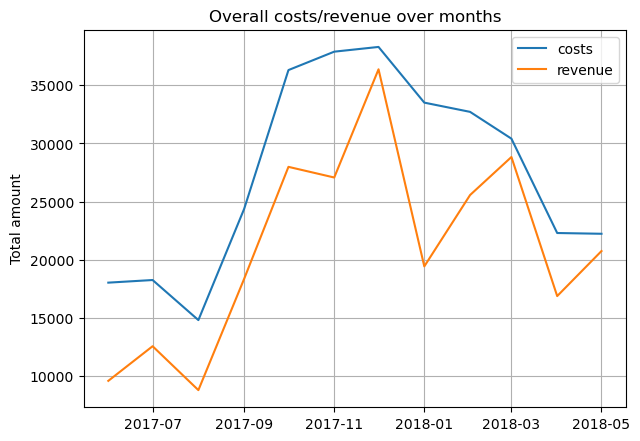

In [161]:
plt.plot(costs.groupby('cost_month').agg({'costs': 'sum'}))
plt.plot(orders.groupby('order_month').agg({'revenue': 'sum'}))
plt.title('Overall costs/revenue over months')
plt.legend(['costs', 'revenue'])
plt.ylabel('Total amount')
plt.grid()
plt.show()

Overall, the costs and revenue month after month follow a similar pattern, except a sharp drop in revenue around January 2018. Could this be due to the 'Holiday fatigue': after the Christmas and the New Year, people are not doing much or not much were going on? Maybe the app could reduce the January spending? 

What's most striking is that there is never an intersection between the costs and revenue. During the period where the data comes from, the revenue never caught up with the cost. This could be serious! We will need to investigate further. 

Let's take a look at the overall expenses by source and customer acquisition cost by source.

#### 5.2 Customer acquisition costs by source

**Costs by source v.s revenue by source**

As orders dataset does not have information on device or source_id, we have to get these from the visits dataset. We can certainly merge the two datasets on 'uid', however, the issue is that one user might have more than one visit using different devices and source_id. Even adding date as the column to merge on, we will find that some users visits the app more than once a day, and it's hard to tell which one results in the order. To make matter even more complicated, they might use different devices for these visits. 

Ideally, the order datasets should include information on device and source_id. Alternatively, the visits data and order data could both include a session id information, which we could use to merge the two datasets. This might be something we can bring to the data department. 

Given the current situation, we will first slice the visits dataset who made an order to include only those who made an order. Then we will find the device and source_id they most often used and use that information for the analysis next.

In [162]:
visits_=visits[visits['uid'].isin(orders['uid'])]

In [163]:
user_info = visits_.groupby('uid')[['device', 'source_id']].apply(
    lambda x: x.mode().iloc[0]).reset_index()

In [164]:
user_info['source_id'] = user_info['source_id'].astype('int')

In [165]:
user_info.head()

,uid,device,source_id
0,313578113262317,desktop,2
1,1575281904278712,touch,10
2,2429014661409475,desktop,3
3,2464366381792757,desktop,5
4,2551852515556206,desktop,5


Let's merge the orders data with the user_info data selecting only the columns we will use later. 

In [166]:
orders_ = pd.merge(orders[['uid', 'revenue', 'order_month', 'first_order_month']],
         user_info, on='uid')

In [167]:
orders_.head()

,uid,revenue,order_month,first_order_month,device,source_id
0,10329302124590727494,17.00,2017-06-01,2017-06-01,desktop,1
1,11627257723692907447,0.55,2017-06-01,2017-06-01,desktop,2
2,17903680561304213844,0.37,2017-06-01,2017-06-01,desktop,2
3,16109239769442553005,0.55,2017-06-01,2017-06-01,desktop,2
4,14200605875248379450,0.37,2017-06-01,2017-06-01,desktop,3


Now we have a data containing both the user information we need and their orders. 

Next, we can use the costs data and orders_ data too compare cost/revenue by source, and t calculate cac and romi by source.

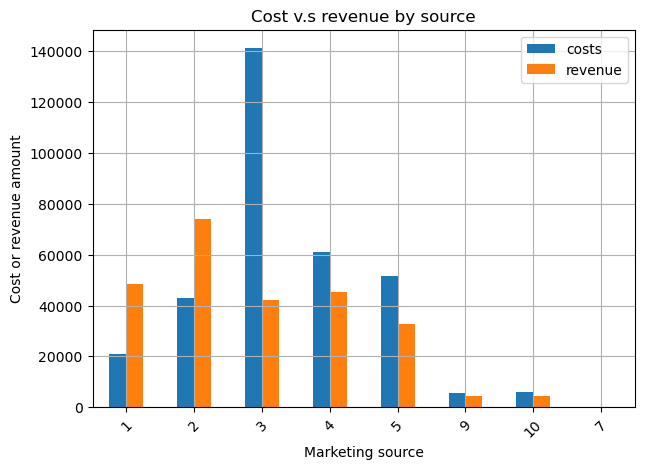

In [168]:
cost_by_source=costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
revenue_by_source = orders_.groupby('source_id').agg({'revenue': 'sum'}).reset_index()
pd.merge(cost_by_source, revenue_by_source, on='source_id', how='outer').plot(x='source_id', kind='bar')
plt.title('Cost v.s revenue by source')
plt.xlabel('Marketing source')
plt.ylabel('Cost or revenue amount')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Overall, expenses on ad source_id 3 is the highest, a total of which reaching almost 140,000. This is followed by ad source_id 4, costing less than half of the former. However, income wise, 3 didn't seem to excel. It is source 2 which generated the most income, followed by 1 and 4. Judging from the graph, source 1 anf 2 are the only ones that are profitable. 

To find out exactly how each marketing source is performing, we will need to calcuate the **cac** and **romi**  metric by source. 

**CAC and ROMI by source**

 First, let's group the costs data by month and source_id. 

In [169]:
costs_by_source_by_month = costs.groupby(['cost_month', 'source_id']).agg({
    'costs': 'sum'
}).reset_index()
costs_by_source_by_month.columns = ['cost_month', 'source_id', 'costs']

In [171]:
costs_by_source_by_month.head()

,cost_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


Before we continue, let's check whether orders_ and costs data contain the same set of source_id's. 

In [172]:
orders_['source_id'].unique()

array([ 1,  2,  3,  5,  4,  9, 10,  7])

In [173]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

Okay. Costs data doesn't have source_id 7. It might be because source_id 7 doesn't cost anything. For now, we will use the source_id's in the cost table to calculate cac and romi. But it's always a good idea to find out more about the business and its products. For example, what these source_id refer to. What happened to 7, or 6 and 8.

Let's define two functions to calculate **cac** and **romi**. 

In [174]:
def color_below_one_red(val):
    color = 'red' if val < 1 else 'black'
    return 'color: %s' % color

In [175]:
def cac(data_orders, data_costs):
    cohort_sizes = data_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month','n_buyers']
    cohorts_revenue = data_orders.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()
    report_revenue = pd.merge(cohort_sizes, cohorts_revenue, on='first_order_month')
    report_revenue['age'] = (report_revenue['order_month'] -
                         report_revenue['first_order_month']) / np.timedelta64(1, 'M')
    report_revenue['age'] = report_revenue['age'].round().astype('int')
    report_revenue['ltv'] = report_revenue['revenue'] / report_revenue['n_buyers']
    report = pd.merge(report_revenue, data_costs,left_on='first_order_month', right_on='cost_month')
    report['cac'] = (report['costs'] / report['n_buyers']).round(2)
    report['first_order_month']=report['first_order_month'].dt.strftime('%Y-%m')
    return report.groupby('first_order_month').agg({'cac': 'mean'}) 

In [176]:
def romi(data_orders, data_costs):
    cohort_sizes = data_orders.groupby('first_order_month').agg(
        {'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    cohorts_revenue = data_orders.groupby(['first_order_month', 'order_month']).agg({
        'revenue': 'sum'}).reset_index()
    report_revenue = pd.merge(
        cohort_sizes, cohorts_revenue, on='first_order_month')
    report_revenue['age'] = (report_revenue['order_month'] -
                             report_revenue['first_order_month']) / np.timedelta64(1, 'M')
    report_revenue['age'] = report_revenue['age'].round().astype('int')
    report_revenue['ltv'] = report_revenue['revenue'] / \
        report_revenue['n_buyers']
    report = pd.merge(report_revenue, data_costs,
                      left_on='first_order_month', right_on='cost_month')
    report['cac'] = report['costs'] / report['n_buyers']
    report['romi'] = report['ltv'] / report['cac']
    report['first_order_month'] = report['first_order_month'].dt.strftime(
        '%Y-%m')
    output = report.pivot_table(
        index='first_order_month', columns='age', values='romi', aggfunc='mean')
    output_cumsum_1 = output.cumsum(axis=1).style.applymap(
        color_below_one_red).format("{:.2f}")
    output_cumsum_2 = output.cumsum(axis=1).mean(
        axis=0).round(2).to_frame().style.applymap(color_below_one_red).format("{:.2f}")
    display(output_cumsum_1)
    display(output_cumsum_2)

Now we will loop the source_id and calculate the cac and return of marketing investment for each source. 

The results will show, for each marketing source, when the cac was paid off for each cohort, as well as how cohorts pay off on average. We will highlight those cac that are not paid off in red. 

In [177]:
source_list = list(costs['source_id'].unique())

In [179]:
for i in source_list:
    data_orders = orders_.query('source_id==@i')
    data_costs = costs_by_source_by_month.query('source_id==@i')
    print('cac for source_id: {0}'.format(i))
    print(cac(data_orders,data_costs))
    print('romi for source_id: {0}'.format(i))
    romi(data_orders,data_costs)

cac for source_id: 1
                    cac
first_order_month      
2017-06            3.98
2017-07            3.89
2017-08            5.29
2017-09            4.15
2017-10            4.11
2017-11            3.86
2017-12            3.67
2018-01            4.86
2018-02            4.54
2018-03            4.12
2018-04            4.16
2018-05            3.60
romi for source_id: 1


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.45,1.71,1.82,2.24,2.44,2.99,3.68,3.93,4.14,4.56,5.25,5.41
2017-07,1.91,2.20,3.12,3.37,3.51,3.68,3.77,3.89,4.01,4.17,4.31,nan
2017-08,1.26,1.40,1.46,1.59,1.68,1.77,1.85,2.17,2.42,2.54,nan,nan
2017-09,1.71,1.89,2.21,2.47,2.67,2.78,3.29,3.44,3.55,nan,nan,nan
2017-10,1.48,1.78,1.82,1.88,1.90,1.91,1.93,1.96,nan,nan,nan,nan
2017-11,1.85,2.08,2.19,2.30,2.33,2.35,2.46,nan,nan,nan,nan,nan
2017-12,1.20,1.26,1.33,1.39,1.45,1.50,nan,nan,nan,nan,nan,nan
2018-01,1.09,1.38,1.60,1.75,1.78,nan,nan,nan,nan,nan,nan,nan
2018-02,1.07,1.25,1.28,1.34,nan,nan,nan,nan,nan,nan,nan,nan


,0
age,
0,1.48
1,1.72
2,1.91
3,2.04
4,2.22
5,2.43
6,2.83
7,3.08
8,3.53


cac for source_id: 2
                     cac
first_order_month       
2017-06             7.42
2017-07             7.73
2017-08             9.58
2017-09             8.03
2017-10             8.34
2017-11             8.38
2017-12             8.49
2018-01             9.83
2018-02            10.08
2018-03             8.37
2018-04            10.36
2018-05             5.63
romi for source_id: 2


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.93,1.08,1.30,1.76,2.20,2.46,2.73,2.98,3.18,3.36,3.43,3.54
2017-07,1.01,1.04,1.07,1.16,1.20,1.22,1.24,1.26,1.29,1.32,1.36,nan
2017-08,0.62,0.71,0.79,0.82,0.86,0.87,0.88,0.92,0.95,0.96,nan,nan
2017-09,1.14,1.89,2.15,5.40,5.62,6.06,6.37,6.48,6.56,nan,nan,nan
2017-10,0.93,1.16,1.23,1.29,1.33,1.38,1.43,1.48,nan,nan,nan,nan
2017-11,0.73,0.81,0.87,0.95,0.98,1.00,1.02,nan,nan,nan,nan,nan
2017-12,0.88,1.01,1.75,2.62,2.85,3.09,nan,nan,nan,nan,nan,nan
2018-01,0.44,0.47,0.56,0.58,0.60,nan,nan,nan,nan,nan,nan,nan
2018-02,0.45,0.49,0.52,0.54,nan,nan,nan,nan,nan,nan,nan,nan


,0
age,
0,0.79
1,0.91
2,1.11
3,1.68
4,1.95
5,2.30
6,2.28
7,2.63
8,3.00


cac for source_id: 3
                     cac
first_order_month       
2017-06            13.61
2017-07            17.09
2017-08            20.34
2017-09            15.12
2017-10            14.86
2017-11            16.72
2017-12            14.44
2018-01            16.71
2018-02            14.58
2018-03            15.16
2018-04            17.00
2018-05            12.24
romi for source_id: 3


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.25,0.25,0.26,0.27,0.27,0.28,0.28,0.28,0.28,0.29,0.29,0.29
2017-07,0.32,0.33,0.33,0.34,0.34,0.34,0.35,0.35,0.35,0.35,0.36,nan
2017-08,0.27,0.27,0.28,0.29,0.30,0.30,0.30,0.31,0.31,0.31,nan,nan
2017-09,0.33,0.34,0.34,0.34,0.34,0.35,0.35,0.35,0.36,nan,nan,nan
2017-10,0.28,0.29,0.29,0.30,0.31,0.31,0.31,0.32,nan,nan,nan,nan
2017-11,0.27,0.27,0.28,0.29,0.29,0.29,0.29,nan,nan,nan,nan,nan
2017-12,0.30,0.30,0.31,0.31,0.32,0.32,nan,nan,nan,nan,nan,nan
2018-01,0.24,0.24,0.24,0.25,0.25,nan,nan,nan,nan,nan,nan,nan
2018-02,0.27,0.28,0.29,0.29,nan,nan,nan,nan,nan,nan,nan,nan


,0
age,
0,0.28
1,0.28
2,0.29
3,0.30
4,0.30
5,0.31
6,0.31
7,0.32
8,0.32


cac for source_id: 4
                     cac
first_order_month       
2017-06             9.23
2017-07             7.90
2017-08            10.35
2017-09             9.72
2017-10             5.98
2017-11             5.23
2017-12             6.11
2018-01             6.24
2018-02             5.86
2018-03             6.29
2018-04             6.92
2018-05             5.99
romi for source_id: 4


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.50,0.51,0.52,0.52,0.54,0.55,0.56,0.56,0.57,0.58,0.60,0.61
2017-07,0.69,0.71,0.72,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,nan
2017-08,0.47,0.49,0.50,0.52,0.54,0.56,0.57,0.58,0.58,0.59,nan,nan
2017-09,0.44,0.47,0.48,0.48,0.49,0.51,0.52,0.52,0.53,nan,nan,nan
2017-10,0.70,0.74,0.76,0.78,0.81,0.82,0.83,0.84,nan,nan,nan,nan
2017-11,0.88,0.96,0.98,1.06,1.10,1.11,1.11,nan,nan,nan,nan,nan
2017-12,0.68,0.69,0.71,0.72,0.73,0.74,nan,nan,nan,nan,nan,nan
2018-01,0.63,0.65,0.66,0.67,0.67,nan,nan,nan,nan,nan,nan,nan
2018-02,0.70,0.72,0.72,0.73,nan,nan,nan,nan,nan,nan,nan,nan


,0
age,
0,0.65
1,0.67
2,0.68
3,0.69
4,0.71
5,0.72
6,0.73
7,0.66
8,0.62


cac for source_id: 5
                     cac
first_order_month       
2017-06             8.66
2017-07             8.69
2017-08             7.80
2017-09             7.67
2017-10             7.89
2017-11            11.87
2017-12            10.07
2018-01            10.49
2018-02             9.04
2018-03            10.04
2018-04            10.45
2018-05             8.28
romi for source_id: 5


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.58,0.69,0.74,0.83,1.06,1.14,1.29,1.39,1.52,1.62,1.66,1.67
2017-07,0.63,0.67,0.68,0.69,0.70,0.70,0.70,0.71,0.71,0.71,0.72,nan
2017-08,0.60,0.72,0.85,0.96,1.13,1.23,1.29,1.32,1.36,1.40,nan,nan
2017-09,0.69,0.71,0.72,0.75,0.75,0.76,0.76,0.77,0.77,nan,nan,nan
2017-10,0.68,0.69,0.70,0.72,0.74,0.74,0.75,0.75,nan,nan,nan,nan
2017-11,0.38,0.39,0.40,0.40,0.42,0.42,0.42,nan,nan,nan,nan,nan
2017-12,0.50,0.51,0.53,0.53,0.53,0.53,nan,nan,nan,nan,nan,nan
2018-01,0.39,0.39,0.40,0.40,0.40,nan,nan,nan,nan,nan,nan,nan
2018-02,0.46,0.47,0.47,0.47,nan,nan,nan,nan,nan,nan,nan,nan


,0
age,
0,0.53
1,0.56
2,0.60
3,0.64
4,0.72
5,0.79
6,0.87
7,0.99
8,1.09


cac for source_id: 9
                     cac
first_order_month       
2017-06             4.19
2017-07             6.05
2017-08             3.61
2017-09             5.77
2017-10             5.08
2017-11             5.65
2017-12             5.53
2018-01             7.50
2018-02             7.55
2018-03             3.25
2018-04            13.83
2018-05             8.23
romi for source_id: 9


age,0,1,2,3,4,5,6,7,8,9,10
first_order_month,,,,,,,,,,,
2017-06,0.81,0.82,0.92,0.96,1.00,1.03,1.12,1.14,1.25,1.25,1.28
2017-07,0.77,0.80,0.88,0.96,1.04,nan,1.09,1.15,1.25,1.25,1.26
2017-08,1.08,1.10,1.26,1.34,1.39,1.41,1.48,1.55,1.64,1.67,nan
2017-09,0.59,0.62,0.64,nan,0.65,0.66,0.67,0.67,nan,nan,nan
2017-10,0.75,0.82,0.87,0.89,0.91,0.94,0.94,0.95,nan,nan,nan
2017-11,0.72,0.75,0.78,0.81,0.81,0.83,0.83,nan,nan,nan,nan
2017-12,0.66,0.70,0.72,0.76,0.81,0.84,nan,nan,nan,nan,nan
2018-01,0.40,0.42,0.44,0.45,0.45,nan,nan,nan,nan,nan,nan
2018-02,0.60,0.63,nan,nan,nan,nan,nan,nan,nan,nan,nan


,0
age,
0,0.67
1,0.72
2,0.81
3,0.88
4,0.88
5,0.95
6,1.02
7,1.09
8,1.38


cac for source_id: 10
                    cac
first_order_month      
2017-06            3.34
2017-07            6.11
2017-08            6.12
2017-09            5.76
2017-10            2.94
2017-11            6.66
2017-12            7.51
2018-01            6.54
2018-02            3.54
2018-03            2.74
2018-04            3.18
2018-05            2.87
romi for source_id: 10


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.72,nan,nan,0.72,nan,0.73,0.73,nan,0.73,nan,nan,0.73
2017-07,0.45,0.45,nan,0.46,nan,0.46,nan,nan,nan,0.47,0.47,nan
2017-08,0.69,0.70,0.75,nan,nan,nan,nan,0.76,nan,nan,nan,nan
2017-09,0.40,0.41,0.42,0.45,0.46,nan,0.46,0.46,0.47,nan,nan,nan
2017-10,0.85,0.88,0.89,0.89,0.92,nan,0.92,0.93,nan,nan,nan,nan
2017-11,0.62,0.63,0.63,0.66,0.67,0.67,0.68,nan,nan,nan,nan,nan
2017-12,0.49,0.51,nan,nan,0.51,nan,nan,nan,nan,nan,nan,nan
2018-01,0.48,0.50,0.51,0.51,nan,nan,nan,nan,nan,nan,nan,nan
2018-02,0.74,0.77,0.77,0.77,nan,nan,nan,nan,nan,nan,nan,nan


,0
age,
0,0.73
1,0.69
2,0.75
3,0.64
4,0.64
5,0.62
6,0.70
7,0.72
8,0.60


The verdict is out! Isn't interesting to see how marketing of different sources perform drastically different! 

Among the 7 marketing sources being analysed here, marketing **source 3** performed the worse. Despite the fact that the company spent the most on source 3, none of the cohorts acquired by it paid off throughout their entire lifetime included in the data. The highest accumulative ROMI it ever achieved is 0.36. **Source 10** also hasn't been paid off by any of the cohorts. 

The next big spender is **source 4**. However, except for the November 2017 cohort which paid off after 3 months, none of the other cohorts paid off the expenses. 

Next, marketing **source 5**. Source 5 performed not great but okay. 2 cohorts paid off after 4 months. 

For **source 9**, two cohorts paid off after 4 months. The August 2017 cohort stood out by paying off in the first month. These cohorts brought up the average cohort romi performance, which is after 6 months. 

The star performer in marketing are **source 1**! All cohorts acquired by source 1 paid off straight away in the first month! The average accumulative romi across all cohorts is already **1.47** in the first month, and reached as high as **5.4** in the 12th month. 

**Source 2** did well too, with three cohorts paid off straight away and 3 cohorts paid off just after 1 month. This brought up the average cohort pay off time to be as early as after 2 months! 

### Part 5 summary 

In this section, we examined the marketing expenses in light of the sales information. 

Overall, we can see that the sales of the company are yet to catch up with marketing. The information on the **cac** and **romi** metrics are especially valuable. It shows that that some of the big marketing spenders are not working effectively to bring profits. The marketing department may have to investigate why this is the case, and if necessary, adjust their strategies in order to keep the business healthy. 

### Part 6: Findings and conclusions 

<a id="conclusion"></a>

In this report, we examined the product, sales, and marketing information about Yandex.Afisha.

The average session by user on a daily basis is just above 1 session, and the figure is slightly higher but still just above 1 on a weekly and even monthly basis. This indicates that the app is attracting visitors all the time, but are also losing them at the same time. 

Although we see some spikes in users and sessions, for example in November 2017, as a result of the increase in marketing spend, the metric of retention rates for user activity shows that these cohorts, despite their initial bigger size, are performing even worse than other cohorts in keeping the users. Therefore how to **keep the users and keep them engaged**, is a key issue for the app company. 

In terms of sessioin duration, we can see that overall desktop users spend longer time with the app than touch device users, an indication that the tech department might need to work on improving user friendliness for touch devices, and remove, or lower any potential barriers to usage or purchase for touch device users. 

Out of the total users who visited the app, 16% eventually made a purcahse. 50% of these users made their first purcahse on the same day of their first visit, 75% within two days. Strikingly, actually half of all purchases by users are made within 3 hours of their first visit to the app. Overall, the app is performing well in encouraing users to purchase. 

An examination of the visit to order conversation by source and device type didn't reveal anything in particular. However, it is worth noting that, despite the number of orders rise and fall, on average the order made by each user is just above 1. Taking into account of the cost of acquiring customers,only two out of 12 cohorts paid off, after 3 and 6 months respectively. For the business to grow, the app will have to attract repeated purchases. 

The study of the marketing cost shows that there is a constant gap between marketing expenses and revenues. While overall, the company's financial health is not looking great, analysis of cac and romi by source reveals that some are performing a lot better than others. Marketing source 1 and 2 are definitely worth further investment because they generate the highest return, whereas source 3 and 4, which currently are costing the most, will need to be further exmained to find out why they have not been doing well so far. Is it the source itself, or there are other factors at play? These will be topics of another analysis.  

Finally, given how to increase user retention is probably beyond the scope of the marketing deparment, those in marketing will need to work with what they are given. 

To start with, it's good to see that overall as marketing expenses increase, the revenue increases as well, although not as much as we would like to see. Therefore it's more a matter of reassessing the worthiness of each marketing source and rebalancing the proportion to invest in each. Having said that, we don't know here which source is which and maybe there is a limit to the profit certain sources could bring. Given what we know from the data, the priority of investment should follow the order of 1, 2, 9, 5, 4, 3, and 10. 

Season wise, potentiallly October to December might be the time worth more marketing investment. The company might also want to cut back the budget a little in January, given the very low user activity that month. 